In [2]:
import os
import numpy as np
from numpy import load, savez_compressed,asarray
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split


https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/

In [ ]:
# # define the discriminator model
# def define_discriminator(image_shape):
# 	# weight initialization
# 	init = RandomNormal(stddev=0.02)
# 	# source image input
# 	in_src_image = Input(shape=image_shape)
# 	# target image input
# 	in_target_image = Input(shape=image_shape)
# 	# concatenate images channel-wise
# 	merged = Concatenate()([in_src_image, in_target_image])
# 	# C64
# 	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
# 	d = LeakyReLU(alpha=0.2)(d)
# 	# C128
# 	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
# 	d = BatchNormalization()(d)
# 	d = LeakyReLU(alpha=0.2)(d)
# 	# C256
# 	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
# 	d = BatchNormalization()(d)
# 	d = LeakyReLU(alpha=0.2)(d)
# 	# C512
# 	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
# 	d = BatchNormalization()(d)
# 	d = LeakyReLU(alpha=0.2)(d)
# 	# second last output layer
# 	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
# 	d = BatchNormalization()(d)
# 	d = LeakyReLU(alpha=0.2)(d)
# 	# patch output
# 	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
# 	patch_out = Activation('sigmoid')(d)
# 	# define model
# 	model = Model([in_src_image, in_target_image], patch_out)
# 	# compile model
# 	opt = Adam(learning_rate=0.0002, beta_1=0.5)
# 	model.compile(loss=BinaryCrossentropy(from_logits=True), optimizer=opt,metrics=['accuracy'])
# 	return model
# # define an encoder block
# def define_encoder_block(layer_in, n_filters, batchnorm=True):
# 	# weight initialization
# 	init = RandomNormal(stddev=0.02)
# 	# add downsampling layer
# 	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
# 	# conditionally add batch normalization
# 	if batchnorm:
# 		g = BatchNormalization()(g, training=True)
# 	# leaky relu activation
# 	g = LeakyReLU(alpha=0.2)(g)
# 	return g

# # define a decoder block
# def decoder_block(layer_in, skip_in, n_filters, dropout=True):
# 	# weight initialization
# 	init = RandomNormal(stddev=0.02)
# 	# add upsampling layer
# 	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
# 	# add batch normalization
# 	g = BatchNormalization()(g, training=True)
# 	# conditionally add dropout
# 	if dropout:
# 		g = Dropout(0.5)(g, training=True)
# 	# merge with skip connection
# 	g = Concatenate()([g, skip_in])
# 	# relu activation
# 	g = Activation('relu')(g)
# 	return g

# # define the standalone generator model
# def define_generator(image_shape=(256,256,3)):
# 	# weight initialization
# 	init = RandomNormal(stddev=0.02)
# 	# image input
# 	in_image = Input(shape=image_shape)
# 	# encoder model
# 	e1 = define_encoder_block(in_image, 64, batchnorm=False)
# 	e2 = define_encoder_block(e1, 128)
# 	e3 = define_encoder_block(e2, 256)
# 	e4 = define_encoder_block(e3, 512)
# 	e5 = define_encoder_block(e4, 512)
# 	e6 = define_encoder_block(e5, 512)
# 	e7 = define_encoder_block(e6, 512)
# 	# bottleneck, no batch norm and relu
# 	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
# 	b = Activation('relu')(b)
# 	# decoder model
# 	d1 = decoder_block(b, e7, 512)
# 	d2 = decoder_block(d1, e6, 512)
# 	d3 = decoder_block(d2, e5, 512)
# 	d4 = decoder_block(d3, e4, 512, dropout=False)
# 	d5 = decoder_block(d4, e3, 256, dropout=False)
# 	d6 = decoder_block(d5, e2, 128, dropout=False)
# 	d7 = decoder_block(d6, e1, 64, dropout=False)
# 	# output
# 	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
# 	out_image = Activation('tanh')(g)
# 	# define model
# 	model = Model(in_image, out_image)
# 	return model
# # define the combined generator and discriminator model, for updating the generator
# def define_gan(g_model, d_model, image_shape):
# 	# make weights in the discriminator not trainable
# 	for layer in d_model.layers:
# 		if not isinstance(layer, BatchNormalization):
# 			layer.trainable = False
# 	# define the source image
# 	in_src = Input(shape=image_shape)
# 	# connect the source image to the generator input
# 	gen_out = g_model(in_src)
# 	# connect the source input and generator output to the discriminator input
# 	dis_out = d_model([in_src, gen_out])
# 	# src image as input, generated image and classification output
# 	model = Model(in_src, [dis_out, gen_out])
# 	# compile model
# 	opt = Adam(learning_rate=0.0002, beta_1=0.5)
# 	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
# 	return model
# # load and prepare training images
# def load_real_samples(filename):
# 	# load compressed arrays
# 	data = load(filename)
# 	# unpack arrays
# 	X1, X2 = data['arr_0'], data['arr_1']
# 	# scale from [0,255] to [-1,1]
# 	X1 = (X1 - 127.5) / 127.5
# 	X2 = (X2 - 127.5) / 127.5
# 	return [X1, X2]
# # select a batch of random samples, returns images and target
# def generate_real_samples(dataset, n_samples, patch_shape):
# 	# unpack dataset
# 	trainA, trainB = dataset
# 	# choose random instances
# 	ix = randint(0, trainA.shape[0], n_samples)
# 	# retrieve selected images
# 	X1, X2 = trainA[ix], trainB[ix]
# 	# generate 'real' class labels (1)
# 	y = ones((n_samples, patch_shape, patch_shape, 1))
# 	return [X1, X2], y
# # generate a batch of images, returns images and targets
# def generate_fake_samples(g_model, samples, patch_shape):
# 	# generate fake instance
# 	X = g_model.predict(samples)
# 	# create 'fake' class labels (0)
# 	y = zeros((len(X), patch_shape, patch_shape, 1))
# 	return X, y

# # generate samples and save as a plot and save the model
# def summarize_performance(step, g_model, dataset, n_samples=3):
# 	# select a sample of input images
# 	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
# 	# generate a batch of fake samples
# 	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
# 	# scale all pixels from [-1,1] to [0,1]
# 	X_realA = (X_realA + 1) / 2.0
# 	X_realB = (X_realB + 1) / 2.0
# 	X_fakeB = (X_fakeB + 1) / 2.0
# 	# plot real source images
# 	for i in range(n_samples):
# 		plt.subplot(3, n_samples, 1 + i)
# 		plt.axis('off')
# 		plt.imshow(X_realA[i])
# 	# plot generated target image
# 	for i in range(n_samples):
# 		plt.subplot(3, n_samples, 1 + n_samples + i)
# 		plt.axis('off')
# 		plt.imshow(X_fakeB[i])
# 	# plot real target image
# 	for i in range(n_samples):
# 		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
# 		plt.axis('off')
# 		plt.imshow(X_realB[i])
# 	# save plot to file
# 	filename1 = 'plot_%06d.png' % (step+1)
# 	plt.savefig(filename1)
# 	plt.close()
# 	# save the generator model
# 	filename2 = 'model_%06d.h5' % (step+1)
# 	g_model.save(filename2)
# 	print('>Saved: %s and %s' % (filename1, filename2))

# # train pix2pix model
# def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
# 	# determine the output square shape of the discriminator
# 	n_patch = d_model.output_shape[1]
# 	# unpack dataset
# 	trainA, trainB = dataset
# 	# calculate the number of batches per training epoch
# 	bat_per_epo = int(len(trainA) / n_batch)
# 	# calculate the number of training iterations
# 	n_steps = bat_per_epo * n_epochs
# 	# manually enumerate epochs
# 	for i in range(n_steps):
# 		# select a batch of real samples
# 		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
# 		# generate a batch of fake samples
# 		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
# 		print(X_realA.shape, X_realB.shape, y_real.shape)
# 		print(X_fakeB.shape, y_fake.shape)

# 		# update discriminator for real samples
# 		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
# 		# update discriminator for generated samples
# 		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
# 		# update the generator
# 		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
# 		# summarize performance
# 		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
# 		# summarize model performance
# 		if (i+1) % (bat_per_epo * 10) == 0:
# 			summarize_performance(i, g_model, dataset)

# dataset = load_real_samples('maps_256.npz')
# print('Loaded', dataset[0].shape, dataset[1].shape)
# # define input shape based on the loaded dataset
# image_shape = dataset[0].shape[1:]
# # define the models
# d_model = define_discriminator(image_shape)
# g_model = define_generator(image_shape)
# # define the composite model
# gan_model = define_gan(g_model, d_model, image_shape)

# # train model
# train(d_model, g_model, gan_model, dataset)
# example of loading a pix2pix model and using it for image to image translation
# from keras.models import load_model
# from numpy import load
# from numpy import vstack
# from matplotlib import pyplot
# from numpy.random import randint

# # load and prepare training images
# def load_real_samples(filename):
# 	# load compressed arrays
# 	data = load(filename)
# 	# unpack arrays
# 	X1, X2 = data['arr_0'], data['arr_1']
# 	# scale from [0,255] to [-1,1]
# 	X1 = (X1 - 127.5) / 127.5
# 	X2 = (X2 - 127.5) / 127.5
# 	return [X1, X2]

# # plot source, generated and target images
# def plot_images(src_img, gen_img, tar_img):
# 	images = vstack((src_img, gen_img, tar_img))
# 	# scale from [-1,1] to [0,1]
# 	images = (images + 1) / 2.0
# 	titles = ['Source', 'Generated', 'Expected']
# 	# plot images row by row
# 	for i in range(len(images)):
# 		# define subplot
# 		plt.subplot(1, 3, 1 + i)
# 		# turn off axis
# 		plt.axis('off')
# 		# plot raw pixel data
# 		plt.imshow(images[i])
# 		# show title
# 		plt.title(titles[i])
# 	plt.show()

# # load dataset
# [X1, X2] = load_real_samples('maps_256.npz')
# print('Loaded', X1.shape, X2.shape)
# # load model
# model = load_model('model_109600.h5')
# # select random example
# ix = randint(0, len(X1), 1)
# src_image, tar_image = X1[ix], X2[ix]
# # generate image from source
# gen_image = model.predict(src_image)
# # plot all three images
# plot_images(src_image, gen_image, tar_image)

In [ ]:
# import os
# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers, Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from matplotlib import pyplot as plt

# # Image loading and preprocessing
# def load_images(path, size=(256, 512)):
#     src_list, tar_list = [], []
#     for filename in os.listdir(path):
#         pixels = load_img(os.path.join(path, filename), target_size=size)
#         pixels = img_to_array(pixels)
#         sat_img, map_img = pixels[:, :256], pixels[:, 256:]
#         src_list.append(sat_img)
#         tar_list.append(map_img)
#     return [np.array(src_list), np.array(tar_list)]

# # dataset path
# path = 'data/maps/train/'
# # load dataset
# [src_images, tar_images] = load_images(path)
# print('Loaded: ', src_images.shape, tar_images.shape)
# # save as compressed numpy array
# filename = 'maps_256.npz'
# savez_compressed(filename, src_images, tar_images)
# print('Saved dataset: ', filename)
# # load the prepared dataset
# from numpy import load
# from matplotlib import pyplot
# # load the dataset
# data = load('maps_256.npz')
# src_images, tar_images = data['arr_0'], data['arr_1']
# print('Loaded: ', src_images.shape, tar_images.shape)
# # plot source images
# n_samples = 3
# for i in range(n_samples):
# 	plt.subplot(2, n_samples, 1 + i)
# 	plt.axis('off')
# 	plt.imshow(src_images[i].astype('uint8'))
# # plot target image
# for i in range(n_samples):
# 	plt.subplot(2, n_samples, 1 + n_samples + i)
# 	plt.axis('off')
# 	plt.imshow(tar_images[i].astype('uint8'))
# plt.show()


# # Discriminator Model
# def build_discriminator(image_shape):
#     def conv_block(inputs, filters, kernel_size=4, strides=2, apply_batchnorm=True):
#         x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
#         if apply_batchnorm:
#             x = layers.BatchNormalization()(x)
#         x = layers.LeakyReLU(alpha=0.2)(x)
#         return x

#     # Inputs
#     source_image = layers.Input(shape=image_shape)
#     target_image = layers.Input(shape=image_shape)
    
#     # Concatenate images
#     x = layers.Concatenate()([source_image, target_image])
    
#     # Discriminator layers
#     x = conv_block(x, 64, apply_batchnorm=False)
#     x = conv_block(x, 128)
#     x = conv_block(x, 256)
#     x = conv_block(x, 512)
#     x = conv_block(x, 512, strides=1)
    
#     x = layers.Conv2D(1, 4, padding='same', activation='sigmoid')(x)
    
#     return Model([source_image, target_image], x)

# # Generator Model
# def build_generator(image_shape):
#     def encoder_block(inputs, filters, apply_batchnorm=True):
#         x = layers.Conv2D(filters, 4, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
#         if apply_batchnorm:
#             x = layers.BatchNormalization()(x)
#         x = layers.LeakyReLU(alpha=0.2)(x)
#         return x

#     def decoder_block(inputs, skip_inputs, filters, dropout=True):
#         x = layers.Conv2DTranspose(filters, 4, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
#         x = layers.BatchNormalization()(x)
#         if dropout:
#             x = layers.Dropout(0.5)(x)
#         x = layers.Concatenate()([x, skip_inputs])
#         x = layers.ReLU()(x)
#         return x

#     inputs = layers.Input(shape=image_shape)
    
#     # Encoder
#     e1 = encoder_block(inputs, 64, apply_batchnorm=False)
#     e2 = encoder_block(e1, 128)
#     e3 = encoder_block(e2, 256)
#     e4 = encoder_block(e3, 512)
#     e5 = encoder_block(e4, 512)
#     e6 = encoder_block(e5, 512)
#     e7 = encoder_block(e6, 512)

#     # Bottleneck
#     b = layers.Conv2D(512, 4, strides=2, padding='same', activation='relu')(e7)

#     # Decoder
#     d1 = decoder_block(b, e7, 512)
#     d2 = decoder_block(d1, e6, 512)
#     d3 = decoder_block(d2, e5, 512)
#     d4 = decoder_block(d3, e4, 512, dropout=False)
#     d5 = decoder_block(d4, e3, 256, dropout=False)
#     d6 = decoder_block(d5, e2, 128, dropout=False)
#     d7 = decoder_block(d6, e1, 64, dropout=False)

#     outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(d7)
    
#     return Model(inputs=inputs, outputs=outputs)

# # GAN Training Setup
# class Pix2Pix:
#     def __init__(self, image_shape):
#         self.image_shape = image_shape
#         self.discriminator = build_discriminator(image_shape)
#         self.generator = build_generator(image_shape)
#         self.gan_model = self.build_gan()

#         self.discriminator.compile(
#             optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
#             loss='binary_crossentropy',
#             metrics=['accuracy']
#         )

#     def build_gan(self):
#         # Freeze discriminator during generator training
#         self.discriminator.trainable = False
        
#         input_source = layers.Input(shape=self.image_shape)
#         generated_image = self.generator(input_source)
#         discriminator_output = self.discriminator([input_source, generated_image])
        
#         gan_model = Model(input_source, [discriminator_output, generated_image])
#         gan_model.compile(
#             optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
#             loss=['binary_crossentropy', 'mae'],
#             loss_weights=[1, 100]
#         )
#         return gan_model

#     # train pix2pix model
#     def train(self, dataset, epochs=100, batch_size=1):
#         # Unpack dataset
#         train_sources, train_targets = dataset
        
#         # Calculate steps per epoch
#         steps_per_epoch = len(train_sources) // batch_size

#         for epoch in range(epochs):
#             for step in range(steps_per_epoch):
#                 # Select batch of real images
#                 start_idx = step * batch_size
#                 end_idx = start_idx + batch_size
#                 real_sources = train_sources[start_idx:end_idx]
#                 real_targets = train_targets[start_idx:end_idx]
                
#                 # Generate fake images
#                 fake_targets = self.generator.predict(real_sources)
                
#                 # Create labels
#                 real_labels = np.ones((batch_size, 16, 16, 1))
#                 fake_labels = np.zeros((batch_size, 16, 16, 1))
                
#                 # Train Discriminator
#                 d_loss_real = self.discriminator.train_on_batch(
#                     [real_sources, real_targets], real_labels
#                 )
#                 d_loss_fake = self.discriminator.train_on_batch(
#                     [real_sources, fake_targets], fake_labels
#                 )
                
#                 # Train Generator via GAN model
#                 g_loss = self.gan_model.train_on_batch(
#                     real_sources, [real_labels, real_targets]
#                 )
                
#                 # Print progress
#                 print(f'Epoch {epoch+1}, Step {step+1}:')
#                 print(f'D Loss (Real): {d_loss_real[0]}, D Acc (Real): {d_loss_real[1]}')
#                 print(f'D Loss (Fake): {d_loss_fake[0]}, D Acc (Fake): {d_loss_fake[1]}')
#                 print(f'G Loss: {g_loss[0]}')
                
#                 # Optional: Add model checkpointing or visualization
#                 if step % 100 == 0:
#                     self.save_samples(real_sources, fake_targets, epoch, step)
        
#     def save_samples(self, sources, generated, epoch, step):
#         plt.figure(figsize=(10, 5))
#         for i in range(min(3, len(sources))):
#             plt.subplot(3, 2, 2*i+1)
#             plt.imshow((sources[i] + 1) / 2.0)
#             plt.title(f'Source {i+1}')
#             plt.subplot(3, 2, 2*i+2)
#             plt.imshow((generated[i] + 1) / 2.0)
#             plt.title(f'Generated {i+1}')
#         plt.tight_layout()
#         plt.savefig(f'samples_epoch_{epoch}_step_{step}.png')
#         plt.close()

#     def save_model(self, path='pix2pix_model'):
#         # Ensure directory exists
#         os.makedirs(path, exist_ok=True)
        
#         # Save generator and discriminator separately
#         self.generator.save(os.path.join(path, 'generator.keras'))
#         self.discriminator.save(os.path.join(path, 'discriminator.keras'))
#         print(f"Models saved to {path}")

#     def load_model(self, path='pix2pix_model'):
#         # Load saved models
#         self.generator = keras.models.load_model(os.path.join(path, 'generator.keras'))
#         self.discriminator = keras.models.load_model(os.path.join(path, 'discriminator.h5'))
        
#         print("Models loaded successfully")

# # Load dataset
# path = 'data/maps/train/'
# [src_images, tar_images] = load_images(path)

# # Normalize images
# src_images = (src_images - 127.5) / 127.5
# tar_images = (tar_images - 127.5) / 127.5

# # Define image shape
# image_shape = (256, 256, 3)

# # Create Pix2Pix model
# pix2pix = Pix2Pix(image_shape)

# # Train the model
# pix2pix.train((src_images, tar_images), epochs=10, batch_size=16)


# pix2pix.generator.save('generator.keras')
# generator = tf.keras.models.load_model('generator.keras')
# # Test the generator
# test_path = "data/maps/val/"
# [src_images_test, tar_images_test] = load_images(test_path)
# num = 4
# test_image = src_images_test[num]
# target_image = tar_images_test[num]
# test_image = img_to_array(test_image) / 127.5 - 1.0
# target_image = img_to_array(target_image) / 127.5 - 1.0

# test_image = np.expand_dims(test_image, axis=0)
# target_image = np.expand_dims(target_image, axis=0) 
# generated_image = generator.predict(test_image)

# plt.subplot(1, 3, 1)
# plt.imshow((test_image[0] + 1) / 2.0)  # Convert back to [0, 1] for visualization
# plt.title("Test Image")
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.imshow((generated_image[0] + 1) / 2.0)  # Convert back to [0, 1] for visualization
# plt.title("Generated Image")
# plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.imshow((target_image[0] + 1) / 2.0)
# plt.title("Target Image")
# plt.axis('off')

# plt.tight_layout()
# plt.show()

In [15]:
# Image loading and preprocessing
def load_images(src_path, tar_path, size=(256, 384)):
    src_list, tar_list = list(), list()

    # Get sorted lists of filenames for both source and target folders
    src_filenames = sorted(os.listdir(src_path))
    tar_filenames = sorted(os.listdir(tar_path))

    # Ensure both folders have the same filenames
    if src_filenames != tar_filenames:
        raise ValueError("Source and target folders do not have matching filenames.")

    # Load and preprocess source images
    for filename in src_filenames:
        # Load and resize the image
        src_pixels = load_img(os.path.join(src_path, filename), target_size=size)
        # Convert to numpy array
        src_pixels = img_to_array(src_pixels)
        src_list.append(src_pixels)

    # Load and preprocess target images
    for filename in tar_filenames:
        # Load and resize the image
        tar_pixels = load_img(os.path.join(tar_path, filename), target_size=size)
        # Convert to numpy array
        tar_pixels = img_to_array(tar_pixels)
        tar_list.append(tar_pixels)

    return [asarray(src_list), asarray(tar_list)]

In [ ]:
original_path = "data/original_images/"
cartoon_path = "data/cartoon_images/"
# load dataset
[original_images, cartoon_images] = load_images(original_path, cartoon_path)
print('Loaded: ', original_images.shape, cartoon_images.shape)
# save as compressed numpy array
filename = 'cars_384.npz'
savez_compressed(filename, original_images, cartoon_images)
print('Saved dataset: ', filename)

Loaded:  (156, 256, 384, 3) (156, 256, 384, 3)
Saved dataset:  cars_384.npz


Loaded:  (156, 256, 384, 3) (156, 256, 384, 3)


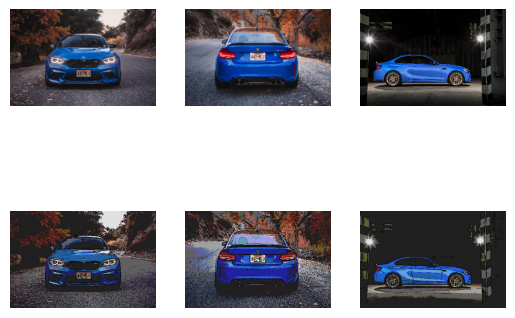

In [3]:
# load the dataset
data = load('cars_384.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(tar_images[i].astype('uint8'))
plt.show()

In [16]:
def build_generator(image_shape):
    def encoder_block(inputs, filters, apply_batchnorm=True):
        x = layers.Conv2D(filters, 4, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
        if apply_batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        return x

    def decoder_block(inputs, skip_inputs, filters, dropout=True):
        x = layers.Conv2DTranspose(filters, 4, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
        x = layers.BatchNormalization()(x)
        
        if dropout:
            x = layers.Dropout(0.5)(x)
        
        # Ensure skip_inputs matches x shape
        if skip_inputs.shape[1:3] != x.shape[1:3]:
            skip_inputs = layers.Resizing(x.shape[1], x.shape[2])(skip_inputs)
        
        x = layers.Concatenate()([x, skip_inputs])
        x = layers.ReLU()(x)
        return x

    inputs = layers.Input(shape=image_shape)

    # Encoder
    e1 = encoder_block(inputs, 64, apply_batchnorm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    e6 = encoder_block(e5, 512)
    e7 = encoder_block(e6, 512)

    # Bottleneck
    b = layers.Conv2D(512, 4, strides=2, padding='same', activation='relu')(e7)

    # Decoder
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)

    # Final layer ensuring output matches input shape
    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(d7)
    outputs = layers.Resizing(image_shape[0], image_shape[1])(outputs)

    return Model(inputs=inputs, outputs=outputs)

def build_discriminator(image_shape):
    def conv_block(inputs, filters, kernel_size=4, strides=2, apply_batchnorm=True):
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
        if apply_batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        return x

    # Inputs
    source_image = layers.Input(shape=image_shape)
    target_image = layers.Input(shape=image_shape)
    
    # Concatenate images
    x = layers.Concatenate()([source_image, target_image])
    
    # Discriminator layers
    x = conv_block(x, 64, apply_batchnorm=False)
    x = conv_block(x, 128)
    x = conv_block(x, 256)
    x = conv_block(x, 512)
    x = conv_block(x, 512, strides=1)
    
    x = layers.Conv2D(1, 4, padding='same', activation='sigmoid')(x)
    
    return Model([source_image, target_image], x)
# GAN Training Setup
class Pix2Pix:
    def __init__(self, image_shape):
        self.image_shape = image_shape
        self.discriminator = build_discriminator(image_shape)
        self.generator = build_generator(image_shape)
        self.gan_model = self.build_gan()

        self.discriminator.compile(
            optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

    def build_gan(self):
        # Freeze discriminator during generator training
        self.discriminator.trainable = False

        input_source = layers.Input(shape=self.image_shape)
        generated_image = self.generator(input_source)
        discriminator_output = self.discriminator([input_source, generated_image])

        gan_model = Model(input_source, [discriminator_output, generated_image])
        gan_model.compile(
            optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
            loss=['binary_crossentropy', 'mae'],
            loss_weights=[1, 100]
        )
        return gan_model


    # train pix2pix model
    def train(self, dataset, epochs=100, batch_size=1):
        # Unpack dataset
        train_sources, train_targets = dataset
        
        # Calculate steps per epoch
        steps_per_epoch = len(train_sources) // batch_size

        for epoch in range(epochs):
            for step in range(steps_per_epoch):
                # Select batch of real images
                start_idx = step * batch_size
                end_idx = start_idx + batch_size
                real_sources = train_sources[start_idx:end_idx]
                real_targets = train_targets[start_idx:end_idx]
                
                # Generate fake images
                fake_targets = self.generator.predict(real_sources)
                
                # Create labels with consistent shape
                # Discriminator output shape is (batch_size, 16, 24, 1)
                real_labels = np.ones((batch_size, 16, 24, 1))
                fake_labels = np.zeros((batch_size, 16, 24, 1))
                
                # Train Discriminator
                d_loss_real = self.discriminator.train_on_batch(
                    [real_sources, real_targets], real_labels
                )
                d_loss_fake = self.discriminator.train_on_batch(
                    [real_sources, fake_targets], fake_labels
                )
                
                # Train Generator via GAN model
                # Note: Generator training uses a different label shape
                g_labels = np.ones((batch_size, 16, 24, 1))
                g_loss = self.gan_model.train_on_batch(
                    real_sources, [g_labels, real_targets]
                )
                
                # Print progress
                print(f'Epoch {epoch+1}, Step {step+1}:')
                print(f'D Loss (Real): {d_loss_real[0]}, D Acc (Real): {d_loss_real[1]}')
                print(f'D Loss (Fake): {d_loss_fake[0]}, D Acc (Fake): {d_loss_fake[1]}')
                print(f'G Loss: {g_loss[0]}')
                
                # Optional: Add model checkpointing or visualization
                if step % 100 == 0:
                    self.save_samples(real_sources, fake_targets, epoch, step)
        
    def save_samples(self, sources, generated, epoch, step):
        plt.figure(figsize=(10, 5))
        for i in range(min(3, len(sources))):
            plt.subplot(3, 2, 2*i+1)
            plt.imshow((sources[i] + 1) / 2.0)
            plt.title(f'Source {i+1}')
            plt.subplot(3, 2, 2*i+2)
            plt.imshow((generated[i] + 1) / 2.0)
            plt.title(f'Generated {i+1}')
        plt.tight_layout()
        plt.savefig(f'samples_epoch_{epoch+1}_step_{step}.png')
        plt.close()

    def evaluate(self, dataset):
        """Evaluate the generator and discriminator on the test dataset."""
        test_sources, test_targets = dataset
        num_samples = len(test_sources)

        # Generate fake images
        fake_targets = self.generator.predict(test_sources)

        # Calculate MAE for generator
        generator_mae = np.mean(np.abs(fake_targets - test_targets))

        # # Calculate SSIM for generator
        # generator_ssim = np.mean([
        #     ssim(
        #         test_targets[i],
        #         fake_targets[i],
        #         multichannel=True,
        #         data_range=fake_targets[i].max() - fake_targets[i].min()
        #     )
        #     for i in range(num_samples)
        # ])

        # Evaluate discriminator on real and fake images
        real_labels = np.ones((num_samples, 16, 24, 1))
        fake_labels = np.zeros((num_samples, 16, 24, 1))

        d_loss_real, d_acc_real = self.discriminator.evaluate(
            [test_sources, test_targets], real_labels, verbose=0
        )
        d_loss_fake, d_acc_fake = self.discriminator.evaluate(
            [test_sources, fake_targets], fake_labels, verbose=0
        )

        # GAN loss
        g_labels = np.ones((num_samples, 16, 24, 1))
        g_loss, gan_discriminator_loss, gan_generator_loss = self.gan_model.evaluate(
            test_sources, [g_labels, test_targets], verbose=0
        )

        # Metrics dictionary
        metrics = {
            "Generator MAE": generator_mae,
            "Discriminator Loss (Real)": d_loss_real,
            "Discriminator Loss (Fake)": d_loss_fake,
            "Discriminator Accuracy (Real)": d_acc_real,
            "Discriminator Accuracy (Fake)": d_acc_fake,
            "GAN Loss": g_loss,
        }

        # Plot metrics
        self.plot_metrics(metrics)

        return metrics

    def plot_metrics(self, metrics):
        """Plot evaluation metrics."""
        fig, ax = plt.subplots(2, 1, figsize=(12, 10))

        # Plot Generator metrics
        ax[0].bar(
            ["Generator MAE"],
            [metrics["Generator MAE"]],
            color=["green"]
        )
        ax[0].set_title("Generator Metrics")
        ax[0].set_ylabel("Value")
        ax[0].grid(True)

        # Plot Discriminator metrics
        ax[1].bar(
            ["D Loss Real", "D Loss Fake", "D Acc Real", "D Acc Fake", "GAN Loss"],
            [
                metrics["Discriminator Loss (Real)"],
                metrics["Discriminator Loss (Fake)"],
                metrics["Discriminator Accuracy (Real)"],
                metrics["Discriminator Accuracy (Fake)"],
                metrics["GAN Loss"],
            ],
            color=["blue", "orange", "cyan", "red", "yellow"]
        )
        ax[1].set_title("Discriminator Metrics")
        ax[1].set_ylabel("Value")
        ax[1].grid(True)

        plt.tight_layout()
        plt.show()

In [18]:
original_path = "data/original_images/"
cartoon_path = "data/cartoon_images/"

# load dataset
[original_images, cartoon_images] = load_images(original_path, cartoon_path, (256, 384))

# Normalize images
original_images = (original_images - 127.5) / 127.5
cartoon_images = (cartoon_images - 127.5) / 127.5

train_original, test_original, train_cartoon, test_cartoon = train_test_split(
    original_images, cartoon_images, test_size=0.2, random_state=42
)

In [19]:
# Define image shape
image_shape = (256, 384, 3)

# Create Pix2Pix model
pix2pix = Pix2Pix(image_shape)

# Train the model
pix2pix.train((train_original, train_cartoon), epochs=15, batch_size=32)

c:\Users\thioy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


c:\Users\thioy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:80: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1, Step 1:
D Loss (Real): 0.5981927514076233, D Acc (Real): 0.6551106572151184
D Loss (Fake): 0.5723285675048828, D Acc (Fake): 0.7591552734375
G Loss: 63.06220626831055
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Epoch 1, Step 2:
D Loss (Real): 0.5971918106079102, D Acc (Real): 0.7042915225028992
D Loss (Fake): 0.5966442823410034, D Acc (Fake): 0.7223307490348816
G Loss: 58.207359313964844
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Epoch 1, Step 3:
D Loss (Real): 0.5921391844749451, D Acc (Real): 0.7135579586029053
D Loss (Fake): 0.603139340877533, D Acc (Fake): 0.6988661289215088
G Loss: 55.784847259521484
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Epoch 1, Step 4:
D Loss (Real): 0.6054520010948181, D Acc (Real): 0.6888369917869568
D Loss (Fake): 0.6158990263938904, D Acc (Fake): 0.6743265986442566
G Loss: 53.13375473022461
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Epoch 1, Step 5:
D Loss (Real): 0.6096459031105042, D Acc (Real): 0.6767668724060059
D Loss (Fake): 0.6263648867607117, D Acc (Fake): 0.653084

In [9]:
# Evaluate and visualize the metrics
metrics = pix2pix.evaluate((test_original, test_cartoon))

17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step


ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.

In [20]:
pix2pix.generator.save('generator_cars2.keras')

In [21]:
generator = tf.keras.models.load_model('generator_cars2.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


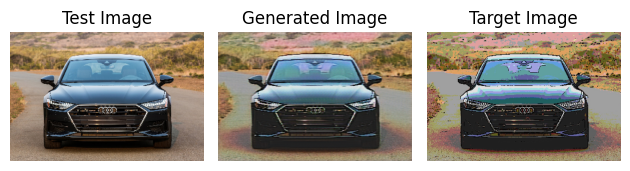

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


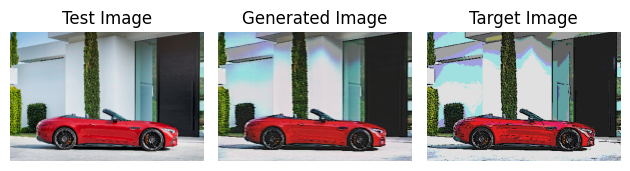

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


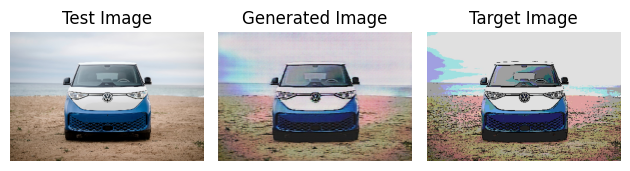

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


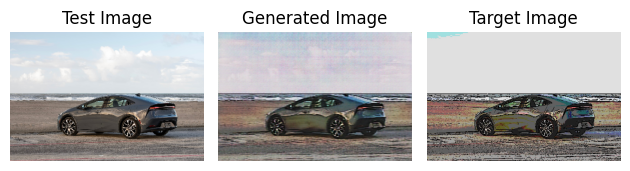

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


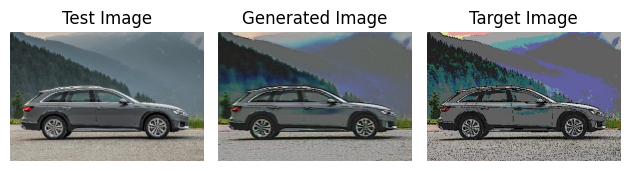

In [22]:
for i in range(5):
    num = np.random.randint(0, len(test_original))
    test_image = test_original[num]
    target_image = test_cartoon[num]

    test_image = np.expand_dims(test_image, axis=0)
    target_image = np.expand_dims(target_image, axis=0) 
    generated_image = generator.predict(test_image)

    plt.subplot(1, 3, 1)
    plt.imshow((test_image[0] + 1) / 2.0)  # Convert back to [0, 1] for visualization
    plt.title("Test Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow((generated_image[0] + 1) / 2.0)  # Convert back to [0, 1] for visualization
    plt.title("Generated Image")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow((target_image[0] + 1) / 2.0)
    plt.title("Target Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

<Figure size 4000x4000 with 0 Axes>

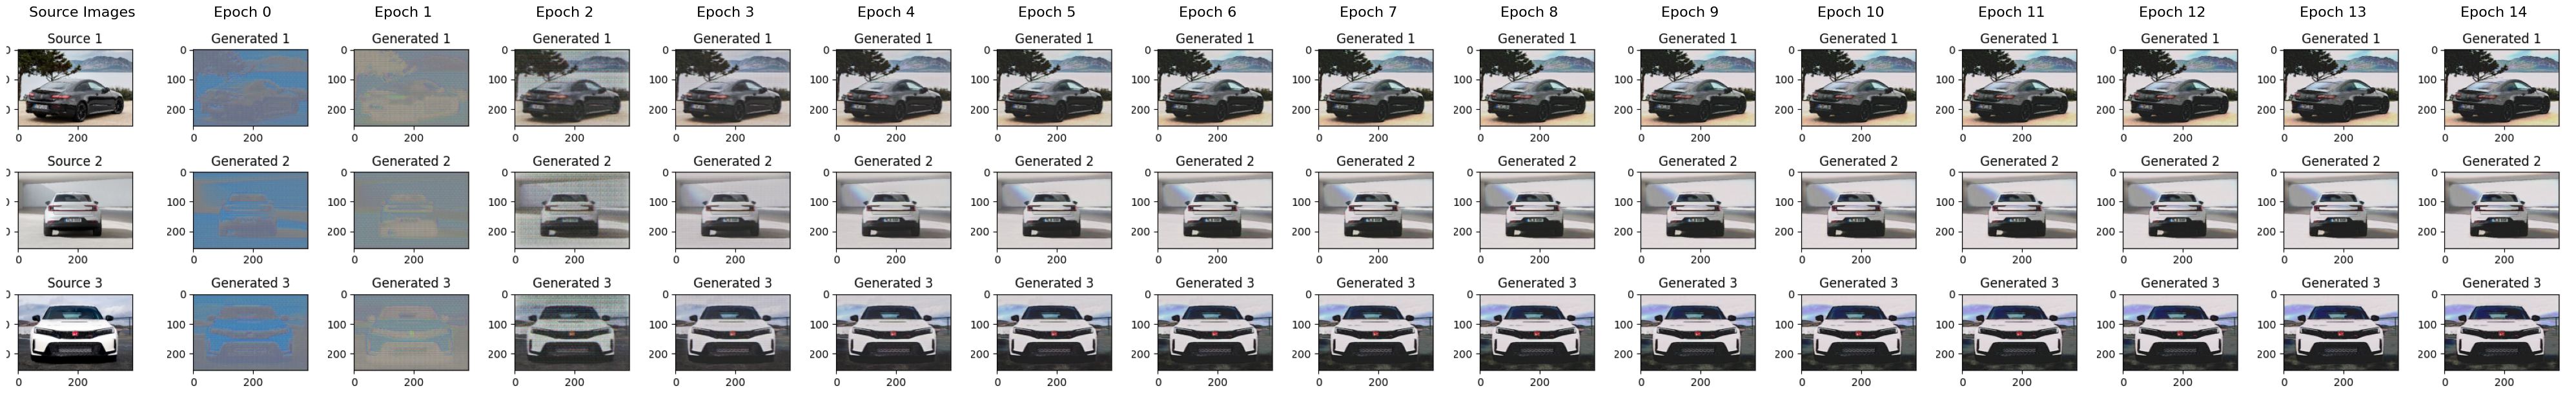

In [25]:
import matplotlib.pyplot as plt
from PIL import Image

# Function to crop the left and right sides of the image
def crop_image(image_path):
    img = Image.open(image_path)
    source_crop = img.crop((200, 0, 400, img.height))  # Source images from 150 to 400
    generated_crop = img.crop((600, 0, 800, img.height))  # Generated images from 600 to 800
    return source_crop, generated_crop


# Initialize variables
base_file = "samples_epoch_0_step_0.png"
num_epochs = 15  # Number of epochs


# Lists to store images for plotting
source_images = []
generated_images = []

# Process the first file (epoch 0)
source_img, gen_img = crop_image(base_file)
source_images = [source_img]  # Source images remain constant
generated_images.append(gen_img)  # Generated images from epoch 0

# Process the remaining files
for i in range(14):
    file_name = f"samples_epoch_{i+1}_step_0.png"
    _, gen_img = crop_image(file_name)  # Only keep the generated part
    generated_images.append(gen_img)

# Plotting
plt.figure(figsize=(40, 40))
fig, axes = plt.subplots(nrows=1, ncols=num_epochs + 1, figsize=(40, 10))  # Larger figure size

# Plot the source images in the first column
axes[0].imshow(source_images[0])  # Only one set of source images
axes[0].axis('off')
axes[0].set_title("Source Images", fontsize=16)

# Plot the generated images in the subsequent columns
for col, gen_img in enumerate(generated_images):
    axes[col + 1].imshow(gen_img)
    axes[col + 1].axis('off')
    axes[col + 1].set_title(f"Epoch {col}", fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()
